In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import obspy
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from glob import glob
from tqdm import tqdm
from obspy.geodetics.base import gps2dist_azimuth
import matplotlib.ticker as ticker

In [2]:
client = Client('IRIS')

In [3]:
origin_time = obspy.UTCDateTime(2021,8,26,8,59,50)

In [4]:
latitude= 44.760
longitude=-110.715
minradius=0
maxradius=1

In [5]:
starttime=origin_time - 1*60
endtime=origin_time + 300

In [6]:
inv = client.get_stations(starttime, endtime, latitude=latitude, 
                    longitude=longitude, minradius=minradius, channel='EH*,HH*,BH*',level='response', 
                    maxradius=maxradius,matchtimeseries=True)

In [7]:
## Common Parameters
f1 = 1
f2 = 10
filter_type = 'bandpass'
dist_range = (0,110)
bins = 25

def get_info(inventory):
    lats = []
    lons = []
    net = []
    sta = []
    loc = []
    chan = []
    for i in range(len(inventory)):
        for k in range(len(inventory[i])):
            for j in range(len(inventory[i][k])):
                net.append(inventory[i].code)
                sta.append(inventory[i][k].code)
                loc.append(inventory[i][k][j].location_code)
                chan.append(inventory[i][k][j].code)
                lats.append(inventory[i][k][j].latitude)
                lons.append(inventory[i][k][j].longitude)

    net = np.array(net)
    sta = np.array(sta)
    loc = np.array(loc)
    chan = np.array(chan)
    lats = np.array(lats)
    lons = np.array(lons)

    df = pd.DataFrame({'Network':net, 'Station':sta, 'Location':loc,'Channel':chan, 'latitude':lats, 'longitude':lons},index=net)
    if len(df[df['Network']=='SY'].values) != 0:
        df.drop(['SY'],inplace=True)
    return df

def compute_snr(trace):
    rms_noise = np.sqrt(np.mean((trace.data[0:30*int(trace.stats.sampling_rate)])**2))
    rms_signal = np.sqrt(np.mean((trace.data[50*int(trace.stats.sampling_rate):80*int(trace.stats.sampling_rate)])**2))
    snr = rms_signal/rms_noise
    return snr

def prs(stream, dist, ba, inventory, channel='*HR', filter_type='bandpass',
       freqmin=f1,freqmax=f2,  bins = 25, dist_range = (0,110)):
    # stream should contain both the N and E component. 
    # Adding distance and back azimuths to all the traces
    for i in range(len(stream)): 
        stream[i].stats.distance = dist[i]
        stream[i].stats.back_azimuth = ba[i]

    
    # removing instrument response    
    stream.remove_response(inventory=inventory,output='DISP')

    # rotating the stream
    stream.rotate(method='NE->RT')


    # converting it into stream
    stream = obspy.Stream(st_dlf)

    # selecting the 'R' channel
    st_R = stream.select(channel=channel)
    
    # selecting new inventory
    inv1 = inventory.select(channel='*HR')

    # adding individual distances which will help in plot
    dist = [] 
    for i in range(len(st_R)):
        dist.append(st_R[i].stats.distance)
    
    
    #st_dlf.taper(max_percentage=0.1)
    st_R.filter(type=filter_type,freqmin=f1, freqmax=f2)

    # Bin size
    a,_ = np.histogram(dist, bins=bins, range=dist_range)
    b = np.cumsum(a)


    # sort stream according to epicentral distance
    st_sorted = []
    dist_sorted = []
    for i in range(len(dist)):
        st_sorted.append(st_R[np.argsort(dist)[i]])
        dist_sorted.append(dist[np.argsort(dist)[i]])
    st_sorted = obspy.Stream(st_sorted)



    # computing snr of the individual bins and then pick out the index of the waveform with highest snr in each bin
    snr = []
    for i in range(b[0]):
        snr.append(compute_snr(st_sorted[i]))
    
    ## pick index of a waveform in first bin and save it
    idx_max = []
    if len(snr) != 0:
        idx_max.append(np.argmax(snr))



    ## pick index of a waveform corresponding to highest SNR of remaining bins. 
    for i in range(len(b)-1):
        snr = []
        idx = []
        for k in range(b[i],b[i+1]):
            snr.append(compute_snr(st_sorted[k]))
            idx.append(k)
        

        try:    
            idx_max.append(idx[np.argmax(snr)])
        except:
            continue
    
    return idx_max, st_sorted, dist_sorted


def axes_plot(index, st_sorted, dist, 
              row = 0, col = 0, scale = 2, ylim = [0,100], xlim = [0,300]):

    dist_labels = []
    ylabels = []
    for k in range(len(index)):
        i = index[k]
        t = np.linspace(0,300,len(st_sorted[i].data))
    
      
        ax1[row,col].plot(t, dist[i]+scale*st_sorted[i].data/np.max(abs(st_sorted[i].data)))
        dist_labels.append(np.around(dist[i],2))
        ylabels.append(st_sorted[i].stats.network+'.'+st_sorted[i].stats.station+'.'+
                  st_sorted[i].stats.channel)

    ax1[row,col].spines['left'].set_linewidth(3)
    ax1[row,col].spines['bottom'].set_linewidth(3)
    ax1[row,col].spines['top'].set_linewidth(3)
    ax1[row,col].spines['right'].set_linewidth(3)
    
    ax2 = ax1[row,col].twinx()
    ax1[row,col].set_yticks(ticks=dist_labels,labels=np.array(dist_labels).astype('str'))  
    ax2.set_yticks(ticks = dist_labels, labels = ylabels)
    ax1[row,col].set_xlim(xlim[0],xlim[1])
    ax1[row,col].set_ylim(ylim[0],ylim[1])
    
    ax2.set_ylim(ylim[0],ylim[1])



## Typical event

In [8]:
origin_time_te = obspy.UTCDateTime(2021,8,25,18,1,34)
latitude_te= 44.781
longitude_te= -110.789
minradius=0
maxradius=1

starttime_te = origin_time_te - 1*60
endtime_te = origin_time_te + 300
inv_te = client.get_stations(starttime_te, endtime_te, latitude=latitude_te, 
                    longitude=longitude_te, minradius=minradius, channel='EH*,HH*,BH*',level='response', 
                    maxradius=maxradius,matchtimeseries=True)

In [11]:
df_te = get_info(inv_te)
stream_te = obspy.Stream([])
for i in tqdm(range(len(df_te['Network']))):
    stream_te += client.get_waveforms(df_te['Network'][i],
                                      df_te['Station'][i],df_te['Location'][i], df_te['Channel'][i],
                                      starttime_te, endtime_te,
                                      attach_response=True)
    
stream_te.write('/home/aakash/Desktop/Reference_Papers/Keith_Koper/Tasks//stream_te.mseed')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 111/111 [05:20<00:00,  2.89s/it]


In [9]:
df_te = get_info(inv_te)
dist_te = []
ba_te = []
for i in range(len(df_te['Network'])):
    dist_te.append(gps2dist_azimuth(latitude_te, longitude_te, df_te['latitude'][i], df_te['longitude'][i])[0]/1000)
    ba_te.append(gps2dist_azimuth(latitude_te, longitude_te, df_te['latitude'][i], df_te['longitude'][i])[1])

In [177]:
stream_dlf = obspy.Stream([])
for i in tqdm(range(len(df['Network']))):
    stream_dlf += client.get_waveforms(df['Network'][i],
                                      df['Station'][i],df['Location'][i], df['Channel'][i],starttime, endtime,
                                      attach_response=True)

100%|████████████████████████████████████████| 110/110 [05:20<00:00,  2.92s/it]


In [179]:
stream_dlf.write('/home/aakash/Desktop/Reference_Papers/Keith_Koper/Tasks//stream_dlf.mseed')

In [181]:
stream_dlf

110 Trace(s) in Stream:

IW.FLWY.00.BH1 | 2021-08-26T08:58:50.000000Z - 2021-08-26T09:04:50.000000Z | 40.0 Hz, 14401 samples
...
(108 other traces)
...
WY.YWB.01.EHZ | 2021-08-26T08:58:50.000000Z - 2021-08-26T09:04:50.000000Z | 100.0 Hz, 36001 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:23<00:00,  7.91s/it]


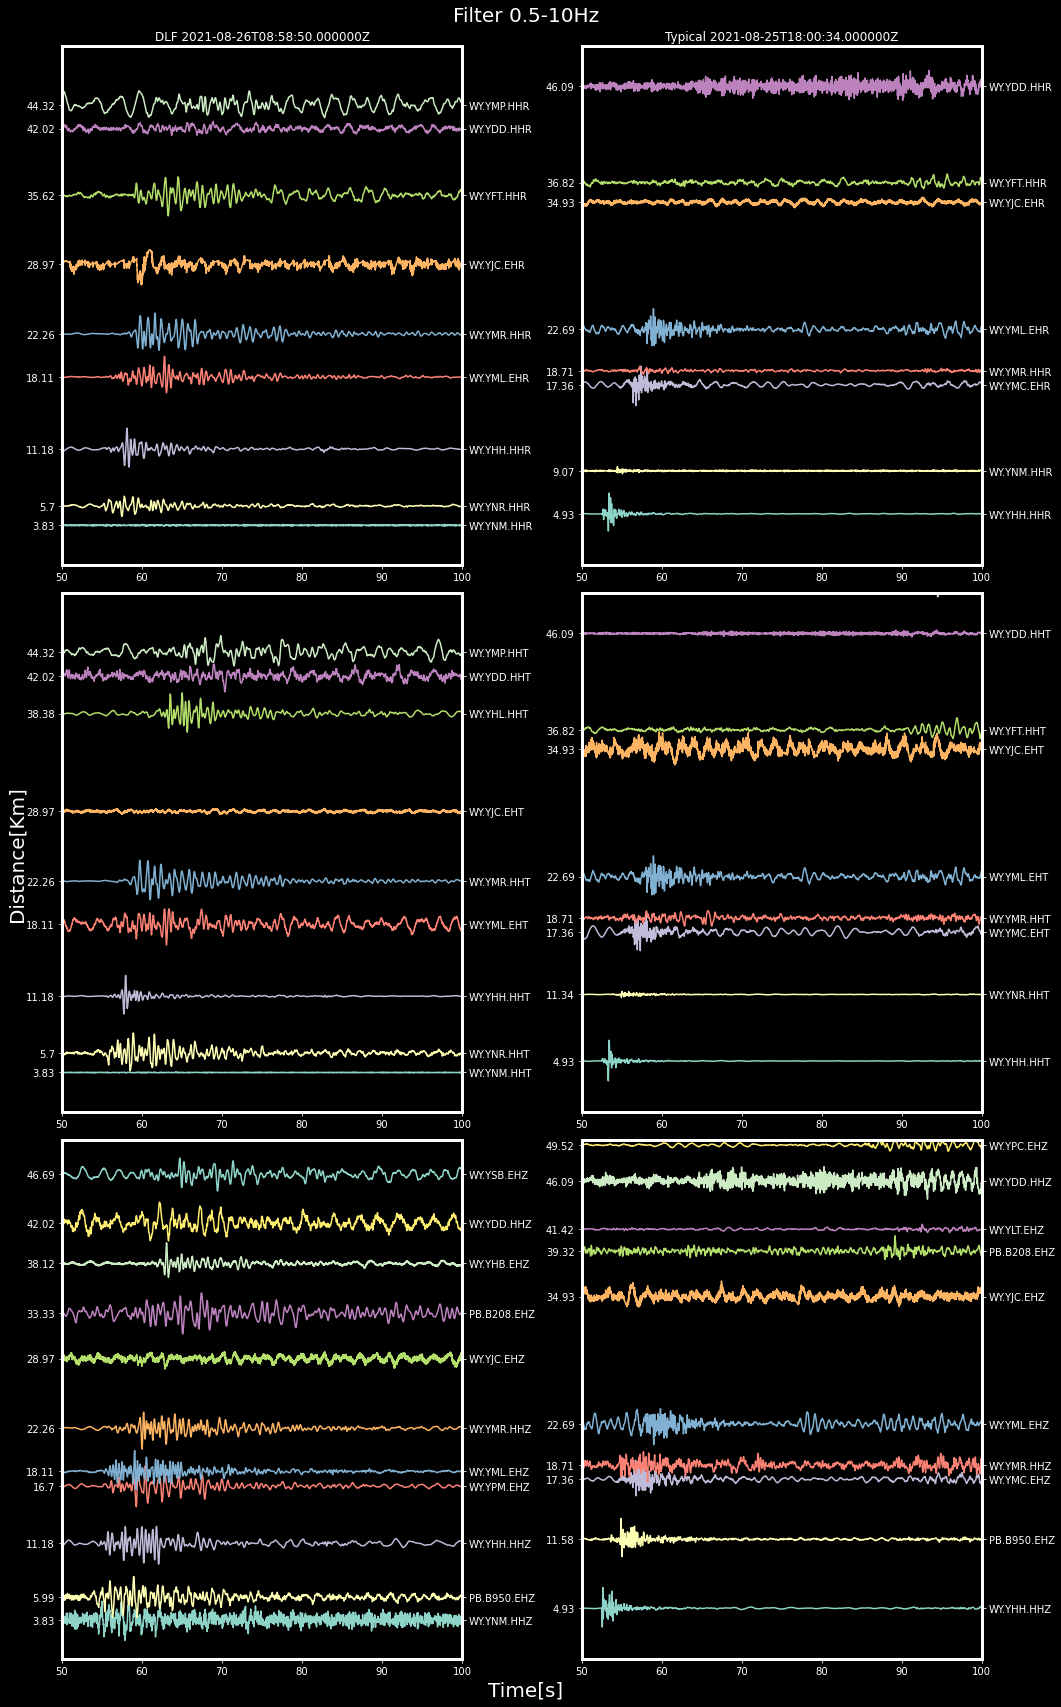

In [10]:
## Common Parameters

f1 = 0.5
f2 = 10
filter_type = 'bandpass'
dist_range = (0,110)
bins = 25
xlim = [50,100]
ylim = [0,50]
chan = ['*HR','*HT','*HZ']





df = get_info(inv)
dist1 = []
ba1 = []
for i in range(len(df['Network'])):
    dist1.append(gps2dist_azimuth(latitude, longitude, df['latitude'][i], df['longitude'][i])[0]/1000)
    ba1.append(gps2dist_azimuth(latitude, longitude, df['latitude'][i], df['longitude'][i])[1])
    

df_te = get_info(inv_te)
dist_te = []
ba_te = []
for i in range(len(df_te['Network'])):
    dist_te.append(gps2dist_azimuth(latitude_te, longitude_te, df_te['latitude'][i], df_te['longitude'][i])[0]/1000)
    ba_te.append(gps2dist_azimuth(latitude_te, longitude_te, df_te['latitude'][i], df_te['longitude'][i])[1])    
    
    

# Importing the stream containing waveforms corresponding to event
stream_dlf = obspy.read('/home/aakash/Desktop/Reference_Papers/Keith_Koper/Tasks//stream_dlf.mseed')
# copying that stream to preserve the original stream
st_dlf = stream_dlf.copy()

plt.style.use('dark_background')
fig, ax1 = plt.subplots(nrows = 3, ncols = 2, figsize=[15,24])

for i in tqdm(range(3)):
    stream_dlf = obspy.read('/home/aakash/Desktop/Reference_Papers/Keith_Koper/Tasks//stream_dlf.mseed')
    st_dlf = stream_dlf.copy()
    idx_max, st_dlf_sorted, dist_sorted = prs(stream=st_dlf, dist=dist1, ba = ba1, inventory=inv, channel=chan[i], 
                                          filter_type='bandpass',
       freqmin=f1,freqmax=f2,  bins = 25, dist_range = (0,110))                                                 
    axes_plot(index = idx_max, st_sorted = st_dlf_sorted, dist = dist_sorted, 
              row = i, col = 0, scale = 2, ylim = ylim, xlim = xlim)
    

    stream_dlf = obspy.read('/home/aakash/Desktop/Reference_Papers/Keith_Koper/Tasks//stream_te.mseed')
    st_dlf = stream_dlf.copy()
    idx_max, st_dlf_sorted, dist_sorted = prs(stream=st_dlf, dist=dist_te, ba = ba_te, inventory=inv_te, channel=chan[i], 
                                          filter_type='bandpass',
       freqmin=f1,freqmax=f2,  bins = bins, dist_range = dist_range)                                                 
    axes_plot(index = idx_max, st_sorted = st_dlf_sorted, dist = dist_sorted, 
              row = i, col = 1, scale = 2, ylim = ylim, xlim = xlim)


    
ax1[0,0].set_title('DLF '+str(origin_time-60))
ax1[0,1].set_title('Typical '+str(origin_time_te-60))
fig.suptitle('Filter '+str(f1)+'-'+str(f2)+'Hz', y = 0.99, fontsize=20)
fig.supylabel('Distance[Km]', fontsize=20)
fig.supxlabel('Time[s]', fontsize=20)
fig.tight_layout()    
    
fig.tight_layout()

In [ ]:
trig = trigger_onset(cf, 1.2, 0.5) / samprate

In [59]:
stream_dlf = obspy.read('/home/aakash/Desktop/Reference_Papers/Keith_Koper/Tasks//stream_dlf.mseed')
st_dlf = stream_dlf.copy()
idx_max, st_dlf_sorted, dist_sorted = prs(stream=st_dlf, dist=dist1, ba = ba1, inventory=inv, channel='*HZ', 
                                          filter_type='bandpass',
       freqmin=f1,freqmax=f2,  bins = 25, dist_range = (0,110))      

In [60]:
st_dlf_sorted

52 Trace(s) in Stream:

WY.YNM.01.HHZ | 2021-08-26T08:58:50.008394Z - 2021-08-26T09:04:49.998394Z | 100.0 Hz, 36000 samples
...
(50 other traces)
...
RE.JKLK2.12.HHZ | 2021-08-26T08:58:50.000000Z - 2021-08-26T09:04:50.000000Z | 100.0 Hz, 36001 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [61]:
idx_max

[0, 2, 4, 6, 8, 10, 13, 16, 20, 24, 30, 33, 38, 39, 41, 43, 45, 50]

52 Trace(s) in Stream:
WY.YNM.01.HHZ   | 2021-08-26T08:58:50.008394Z - 2021-08-26T09:04:49.998394Z | 100.0 Hz, 36000 samples
WY.YNR.01.HHZ   | 2021-08-26T08:58:50.008393Z - 2021-08-26T09:04:49.998393Z | 100.0 Hz, 36000 samples
PB.B950..EHZ    | 2021-08-26T08:58:50.008400Z - 2021-08-26T09:04:49.998400Z | 100.0 Hz, 36000 samples
WY.YHH.01.EHZ   | 2021-08-26T08:58:50.000000Z - 2021-08-26T09:04:50.000000Z | 100.0 Hz, 36001 samples
WY.YHH.01.HHZ   | 2021-08-26T08:58:50.008400Z - 2021-08-26T09:04:49.998400Z | 100.0 Hz, 36000 samples
PB.B945..EHZ    | 2021-08-26T08:58:50.008400Z - 2021-08-26T09:04:49.998400Z | 100.0 Hz, 36000 samples
WY.YPM.01.EHZ   | 2021-08-26T08:58:50.000000Z - 2021-08-26T09:04:50.000000Z | 100.0 Hz, 36001 samples
PB.B206..EHZ    | 2021-08-26T08:58:50.008400Z - 2021-08-26T09:04:49.998400Z | 100.0 Hz, 36000 samples
WY.YML.01.EHZ   | 2021-08-26T08:58:50.000000Z - 2021-08-26T09:04:50.000000Z | 100.0 Hz, 36001 samples
PB.B207..EHZ    | 2021-08-26T08:58:50.008400Z - 2021-08-26T

In [18]:
dist_sorted

[3.828806292652819,
 5.701602401639211,
 5.989384773839597,
 11.178127952267525,
 11.178127952267525,
 15.06811770163148,
 16.69950770214356,
 16.774041557663462,
 18.10663536935521,
 18.907756624207025,
 22.25797502943238,
 23.05292191826259,
 23.83480199747313,
 28.970116569743453,
 31.247029902419047,
 33.05604440893465,
 33.33450437054642,
 35.059718516934176,
 35.6166378875092,
 37.28243743576715,
 38.11583605989508,
 38.11583605989508,
 38.3781864240448,
 41.93610507086998,
 42.02079870494433,
 43.23893931607105,
 43.337367855518515,
 44.32129067159483,
 44.32129067159483,
 44.82822862920245,
 46.68690521314485,
 53.293987818970116,
 53.293987818970116,
 54.80276127827727,
 54.80276127827727,
 57.090509535671735,
 57.118103463516675,
 62.266424368960344,
 62.8844701346737,
 73.42784925762051,
 75.23796402604938,
 75.36572133983339,
 76.54712846613127,
 88.4567119693864,
 89.58884039558397,
 96.76935921867016,
 98.04434262113888,
 98.91592357495861,
 100.32627265145504,
 100.34827

In [20]:
len(idx_max)

18

In [21]:
stream_dlf = obspy.read('/home/aakash/Desktop/Reference_Papers/Keith_Koper/Tasks//stream_dlf.mseed')

In [22]:
dlf_Z = stream_dlf.select(channel='*HZ')

In [26]:
idx_max

[0, 2, 4, 6, 8, 10, 13, 16, 20, 24, 30, 33, 38, 39, 41, 43, 45, 50]

In [62]:
dlf_Z = st_dlf_sorted
dep_dlf = 14.2
lat_dlf = 44.760
lon_dlf =-110.715
for i in tqdm(range(len(idx_max))):
    k = idx_max[i]
    sta = dlf_Z[k].stats.station
    net = dlf_Z[k].stats.network
    loc = dlf_Z[k].stats.location
    inv_sta = inv.select(network = net, station=sta, location = loc)
    slon = inv_sta[0][0].longitude
    slat = inv_sta[0][0].latitude
    selv = inv_sta[0][0].elevation
    epi_dlf = gps2dist_azimuth(lat_dlf, lon_dlf, slat, slon)[0]/1000
    hyp_dlf = (epi_dlf**2+dep_dlf**2)**(0.5)
    
    dlf_Z[k].stats['dep'] = dep_dlf
    dlf_Z[k].stats['olon'] = lon_dlf
    dlf_Z[k].stats['olat'] = lat_dlf
    dlf_Z[k].stats['slon'] = slon
    dlf_Z[k].stats['slat'] = slat
    dlf_Z[k].stats['selv'] = selv
    dlf_Z[k].stats['repi'] = epi_dlf
    dlf_Z[k].stats['rhyp'] = hyp_dlf
    dlf_Z[k].write('/home/aakash/Desktop/Reference_Papers/Keith_Koper/Tasks/Task_3/DLF_Keith//'+dlf_Z[k].id+'.mseed')

  0%|                                                                                                                                                                               | 0/18 [00:00<?, ?it/s]/home/aakash/anaconda3/envs/roses_2021/lib/python3.9/site-packages/obspy/io/mseed/core.py:790: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 147.36it/s]


In [47]:
file = glob('/home/aakash/Desktop/Reference_Papers/Keith_Koper/Tasks/Task_3/DLF_Keith/*')

In [50]:
a = obspy.read(file[-1])

In [52]:
a[0].stats

         network: WY
         station: YJC
        location: 01
         channel: EHZ
       starttime: 2021-08-26T08:58:50.000000Z
         endtime: 2021-08-26T09:04:50.000000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 36001
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'M', 'number_of_records': 50, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 512, 'filesize': 25600})

In [42]:
glob('*')

['Untitled1.ipynb',
 'DLF',
 'test1.py',
 'test.py.ipynb',
 'main.py',
 'stations',
 'Task_3(c).ipynb',
 'Task_1b.ipynb',
 'Task_1.ipynb',
 'Untitled2.ipynb',
 'waveforms',
 'Tonga',
 'Task_2b_Akash.ipynb',
 'Task_3b.ipynb',
 'Task_3b_SpecMod.ipynb',
 'test.py',
 'MSEED',
 'Task_2_Yellowstone_Animation.ipynb',
 'Untitled.ipynb']

In [54]:
dist_sorted[idx_max]

TypeError: list indices must be integers or slices, not list

In [55]:
dist_sorted

[3.828806292652819,
 5.701602401639211,
 5.989384773839597,
 11.178127952267525,
 11.178127952267525,
 15.06811770163148,
 16.69950770214356,
 16.774041557663462,
 18.10663536935521,
 18.907756624207025,
 22.25797502943238,
 23.05292191826259,
 23.83480199747313,
 28.970116569743453,
 31.247029902419047,
 33.05604440893465,
 33.33450437054642,
 35.059718516934176,
 35.6166378875092,
 37.28243743576715,
 38.11583605989508,
 38.11583605989508,
 38.3781864240448,
 41.93610507086998,
 42.02079870494433,
 43.23893931607105,
 43.337367855518515,
 44.32129067159483,
 44.32129067159483,
 44.82822862920245,
 46.68690521314485,
 53.293987818970116,
 53.293987818970116,
 54.80276127827727,
 54.80276127827727,
 57.090509535671735,
 57.118103463516675,
 62.266424368960344,
 62.8844701346737,
 73.42784925762051,
 75.23796402604938,
 75.36572133983339,
 76.54712846613127,
 88.4567119693864,
 89.58884039558397,
 96.76935921867016,
 98.04434262113888,
 98.91592357495861,
 100.32627265145504,
 100.34827

In [64]:
idx_max

[0, 2, 4, 6, 8, 10, 13, 16, 20, 24, 30, 33, 38, 39, 41, 43, 45, 50]